In [ ]:
from google.colab import files
!pip install kaggle
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [00:18<00:00, 66.4MB/s]
100% 2.29G/2.29G [00:18<00:00, 133MB/s] 


In [ ]:
#extracte data from zipfile
import zipfile
zf = "/content/chest-xray-pneumonia.zip"
target_dir = "/content/dataset/pneumonia"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)



# Import libraries.


In [1]:
# Core
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns;
import glob
import random
import os
import cv2
import pickle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
#tesor fow & keras
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2     
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense,BatchNormalization,Dropout,Input
from keras.models import Sequential, Model
from keras.layers import Conv2D,GlobalMaxPooling2D
import os
from tensorflow.keras.applications import  Xception,VGG16,InceptionResNetV2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#cnn
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.engine.base_layer import Layer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
seed = 42
np.random.seed =seed

In [4]:
image_path = '/content/dataset/pneumonia/chest_xray/'

# bussiness task

We Want to build powerful Neural network that can classify is there Pneumonia or not based on dataset.

.**Pneumonia** is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

# Helper Function




In [5]:
# here in this function i collect my data depending on label name 
labels = ['NORMAL','PNEUMONIA']
folders=['train','test','val']
def load_images_from_directory(main_dirictory,foldername):
    total_labels=[]
    images=[]
    total_normal=0
    total_pneumonia=0
    path = os.path.join(main_dirictory,foldername) 
    for lab in labels :
        full_path = os.path.join(path,lab)
        print (' loading ....... images of folder :',foldername+'/'+lab )  
        for image in os.listdir(full_path):
            img = cv2.imread(full_path+'/'+image)
            img = cv2.resize(img,(150,150))
            images.append(img)
            if lab  == 'NORMAL':
                    label =0
                    total_normal+= 1
            elif lab == 'PNEUMONIA' :
                    label = 1
                    total_pneumonia +=1
            total_labels.append(label)
    print('total normal image := ',total_normal)
    print('total Pneumonia    := ',total_pneumonia)
    return shuffle(images,total_labels,random_state=756349782)

# get label Name   
def get_Label(number):
    labels = {0:'NORMAL', 1:'PNEUMONIA'}
    return labels[number]


#plot predction function
def plot_predection(model_name):
    plt.figure(figsize=(20,15))
    plt.suptitle("Predection  Images", fontsize=20)
    images = [] 
    count = 0  #val_images,val_labels
    for i,files in enumerate(val_images) :
        # img = cv2.imread(files)  
        plt.imshow(files,cmap=plt.cm.binary)
        img = cv2.resize(files,(150,150))
        img = np.expand_dims(files, axis=0)
        feature = model_name.predict(img)
        predection  = np.argmax(feature, axis=1)
        plt.subplot(5,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel("Predected "+get_Label(int(predection)))
        plt.ylabel(get_Label(val_labels[i]))
        count += 1
        if count == 30 :
            break 

def freezing_layers(model_name):
    for layer in model_name.layers:
      layer.trainable = False                    


# Data Preperation 
Load Images
*   Train images
*   Test images
*   Validation images



In [6]:
train_images,train_labels=load_images_from_directory(image_path,"train")

 loading ....... images of folder : train/NORMAL
 loading ....... images of folder : train/PNEUMONIA
total normal image :=  1341
total Pneumonia    :=  3875


In [7]:
test_images,test_labels=load_images_from_directory(image_path,"test")

 loading ....... images of folder : test/NORMAL
 loading ....... images of folder : test/PNEUMONIA
total normal image :=  234
total Pneumonia    :=  390


In [8]:
val_images,val_labels=load_images_from_directory(image_path,"val")

 loading ....... images of folder : val/NORMAL
 loading ....... images of folder : val/PNEUMONIA
total normal image :=  8
total Pneumonia    :=  8


In [9]:
train_images  = np.asarray(train_images,np.float32)/255
train_labels = np.asarray(train_labels)

In [10]:
print('train Images shape is   : ',train_images.shape)
print('train  Labels  shape is : ',train_labels.shape)

train Images shape is   :  (5216, 150, 150, 3)
train  Labels  shape is :  (5216,)


In [11]:
test_images  = np.asarray(test_images,np.float32)/255
test_labels = np.asarray(test_labels)

In [12]:
print('test Images shape is   : ',test_images.shape)
print('test  Labels  shape is : ',test_labels.shape)

test Images shape is   :  (624, 150, 150, 3)
test  Labels  shape is :  (624,)


# Virsialization Train Images 

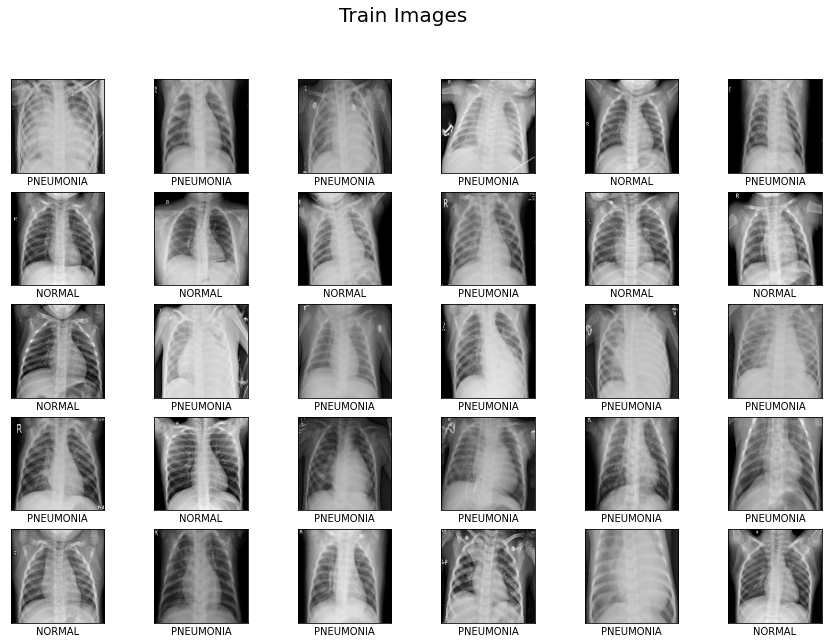

In [ ]:
plt.figure(figsize=(15,10))
plt.suptitle("Train Images", fontsize=20)
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(get_Label(train_labels[i]))
    plt.imshow(train_images[i], cmap=plt.cm.binary)

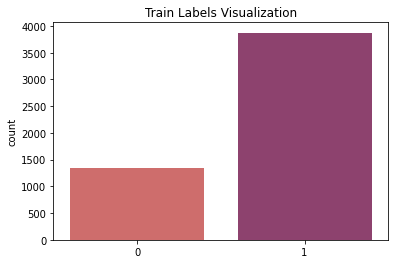

In [ ]:
plt.title('Train Labels Visualization')
sns.countplot(x=train_labels,palette='flare')
plt.show()

# Virsialization Test Images 

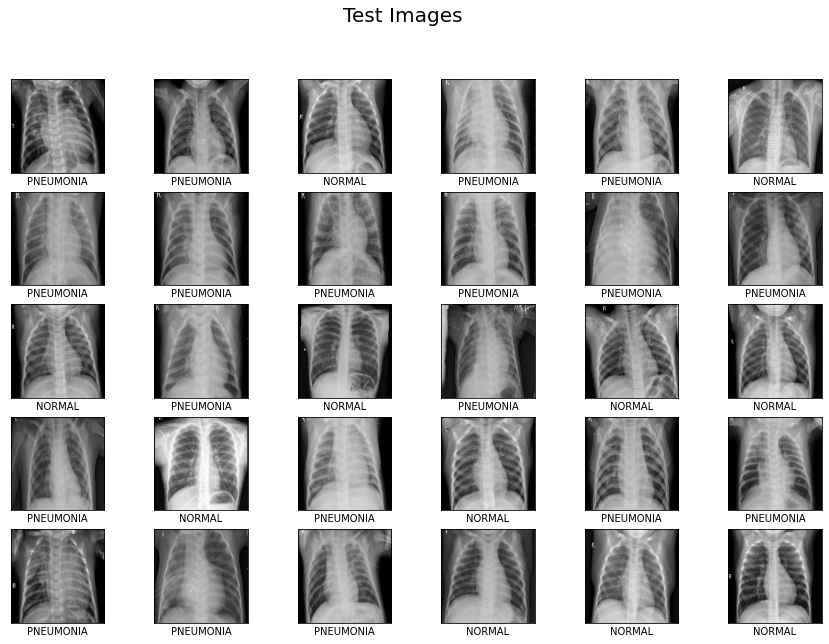

In [ ]:
plt.figure(figsize=(15,10))
plt.suptitle("Test Images", fontsize=20)
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(get_Label(test_labels[i]))
    plt.imshow(test_images[i], cmap=plt.cm.binary)

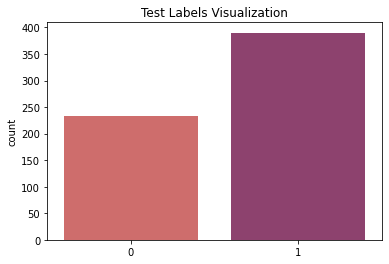

In [ ]:
plt.title('Test Labels Visualization')
sns.countplot(x=test_labels,palette='flare')
plt.show()

In [13]:
train_labels = to_categorical(train_labels, 2)
test_labels = to_categorical(test_labels, 2)

# Buliding CNN Model

**i will use Data augmentation,as it  is a set of techniques to artificially increase the amount of data by generating new data points from existing data. This includes making small changes to data or using deep learning models to generate new data points.** 



In [14]:
batch_size = 16
#create image generator for images 
image_gen = ImageDataGenerator(
                                 # rescale = 1./255,
                                #   shear_range = 0.2,
                                #   zoom_range = 0.2,
                                #   height_shift_range=0.2,
                                #   width_shift_range=0.2,
                                #   fill_mode='nearest',
                                #    horizontal_flip=True,  
                                shear_range = 0.2,
                                  zoom_range = 0.2,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                   horizontal_flip=True, 
                                    rotation_range = 20,   

                               )

# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator()
val_data_gen  = ImageDataGenerator()

train = image_gen.flow(
      train_images,
      train_labels,
      shuffle=True, 
      batch_size=batch_size
      )
test = test_data_gen.flow(
      test_images,
      test_labels,
      shuffle=True, 
      batch_size=batch_size
      )


In [ ]:
cnn_model = Sequential()
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(300,(5,5), kernel_regularizer=l2(0.00005),padding ='Same',activation = 'relu',input_shape=(150,150,3)))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D(2,2))
cnn_model.add(layers.Conv2D(200,(3,3) ,kernel_regularizer=l2(0.00005),padding ='same',activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.2))
cnn_model.add(layers.MaxPooling2D(2,2))
cnn_model.add(layers.Conv2D(100,(3,3) ,kernel_regularizer=l2(0.00005),padding ='same',activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D(2,2)) 
cnn_model.add(layers.Conv2D(64,(3,3) ,kernel_regularizer=l2(0.00005),padding ='same',activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.2))
cnn_model.add(layers.MaxPooling2D(2,2)) 


In [ ]:

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(100, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.3))
cnn_model.add(layers.Dense(2, activation ='sigmoid'))
cnn_model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 150, 150, 300)     22800     
                                                                 
 batch_normalization_40 (Bat  (None, 150, 150, 300)    1200      
 chNormalization)                                                
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 75, 75, 300)      0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 75, 75, 200)       540200    
                                                                 
 batch_normalization_41 (Bat  (None, 75, 75, 200)      800       
 chNormalization)                                                
                                                     

In [ ]:
cnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'],)

  **1-Defining Callbacks**

*   A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)


**2-Reduce Learning Rate on Plateau**
*   Is used to reduce the learning rate when a metric has stopped improving.



In [20]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor="loss", mode="min",min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
# Training model
n_training_samples = len(train)
n_validation_samples = len(test)
history = cnn_model.fit(
    train,
    epochs=50,
    validation_data=test,
    validation_steps=n_validation_samples//batch_size,
    # steps_per_epoch =n_training_samples//batch_size,
    shuffle = True,
    callbacks=callbacks_list
    )

Epoch 1/50
326/326 [==============================] - 31s 90ms/step - loss: 0.4871 - accuracy: 0.8041 - val_loss: 1.4453 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 2/50
326/326 [==============================] - 29s 87ms/step - loss: 0.3742 - accuracy: 0.8566 - val_loss: 1.0596 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 3/50
326/326 [==============================] - 29s 87ms/step - loss: 0.3404 - accuracy: 0.8666 - val_loss: 2.2235 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 4/50
326/326 [==============================] - 29s 89ms/step - loss: 0.3119 - accuracy: 0.8783 - val_loss: 3.6520 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 5/50
326/326 [==============================] - 29s 87ms/step - loss: 0.3002 - accuracy: 0.8827 - val_loss: 0.6387 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/50
326/326 [==============================] - 28s 87ms/step - loss: 0.3014 - accuracy: 0.8769 - val_loss: 1.6332 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/50
326/326 [==============================] - 28s 

In [ ]:
score, acc = cnn_model.evaluate(test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

39/39 [==============================] - 1s 18ms/step - loss: 0.2928 - accuracy: 0.9119
Test score: 0.2928231656551361
Test accuracy: 0.9118589758872986


In [ ]:
cnn_model.save('/content/drive/MyDrive/model_result/chest_x_ray/x_ray_CNN91%acc.h5')

In [ ]:
cnn_prediction = cnn_model.predict(test_images)

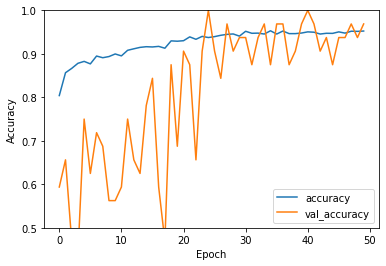

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

# Predction Using CNN.

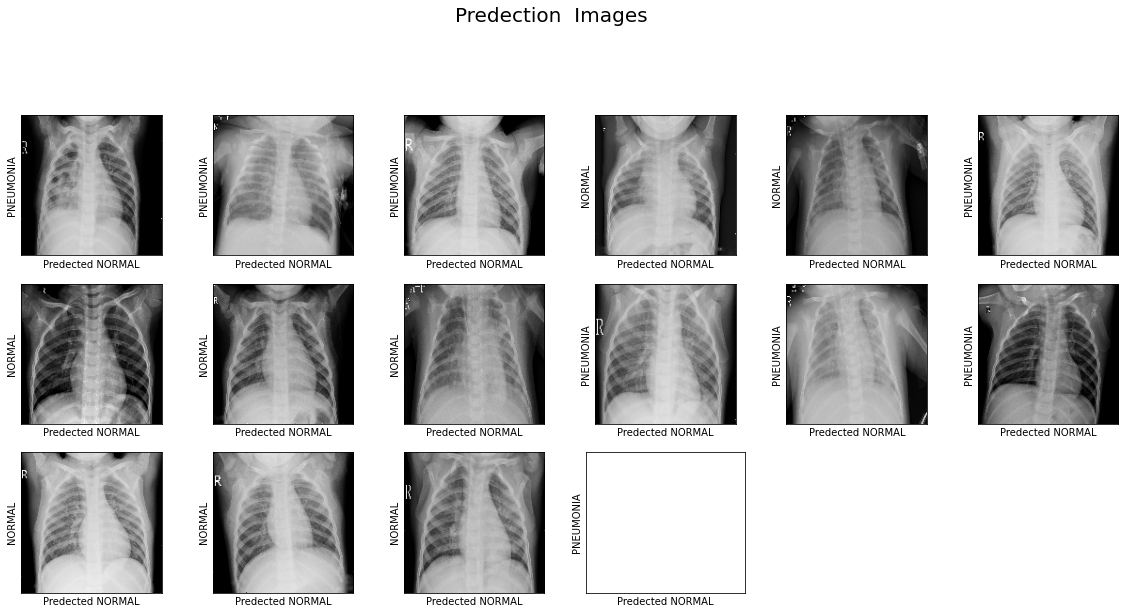

In [ ]:
plot_predection(cnn_model)       

In [ ]:

y_pred = np.argmax(cnn_prediction, axis=1)
y_test = np.argmax(test_labels, axis=1)
print('f1 Score : ',f1_score(y_test, y_pred, average="macro"))
print('recall  :',   recall_score(y_test,y_pred,average="macro"))
print('precision ',precision_score(y_test,y_pred,average="macro"))


f1 Score :  0.9018797798584804
recall  : 0.8876068376068376
precision  0.9277112075740904


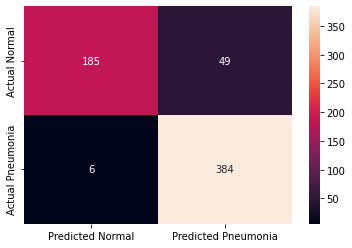

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87       234
           1       0.89      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624



# Transfer learning 
i will use  below models  traying to get more accuarcvy


1.   VGG16
2.  InceptionResNetV2
3.  xception






Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task.

Transfer learning is an optimization that allows rapid progress or improved performance when modeling the second task.

Transfer learning is related to problems such as multi-task learning and concept drift and is not exclusively an area of study for deep learning.

Nevertheless, transfer learning is popular in deep learning given the enormous resources required to train deep learning models or the large and challenging datasets on which deep learning models are trained.

Transfer learning only works in deep learning if the model features learned from the first task are general.

# VGG16 Model

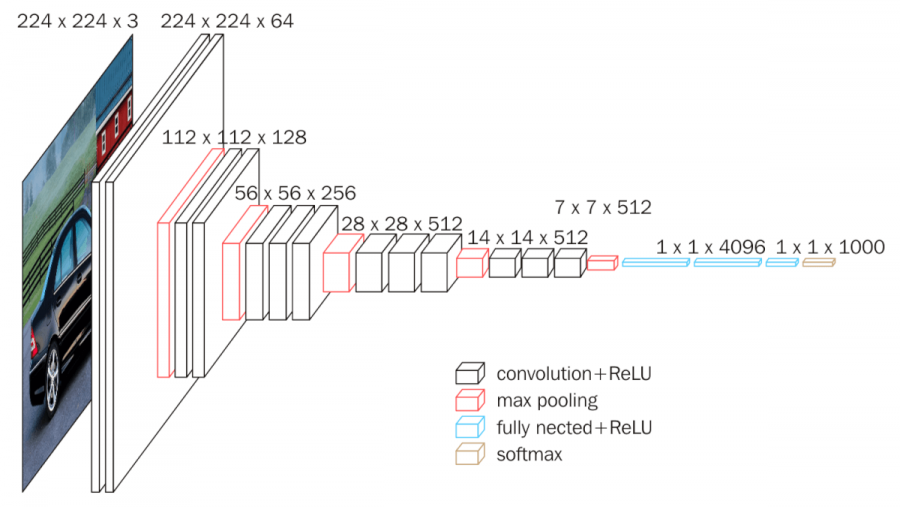

In [ ]:
from IPython.display import Image
Image(filename="/content/drive/MyDrive/datasets/vgg16-1-e1542731207177.png")

VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It was one of the famous model submitted to ILSVRC-2014. It makes the improvement over AlexNet by replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another. VGG16 was trained for weeks and was using NVIDIA Titan Black GPU’s.

# Handel VGG model 

1. chose VGG model Layer to be addaptive with  our data 
2. load VGG Weights  
3. removing dense layer from model




In [ ]:
vgg_base_model = VGG16(input_shape=(150,150,3),weights='imagenet', include_top=False)
vgg_base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
#freezing layers
freezing_layers(vgg_base_model)    

In [ ]:
vgg_model = Sequential()
vgg_model.add(vgg_base_model)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(2048, activation='relu'))
vgg_model.add(BatchNormalization())
vgg_model.add(Dropout(0.5))
vgg_model.add(layers.Dense(2, activation ='sigmoid'))
vgg_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2048)              16779264  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                        

In [ ]:
vgg_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'],)

In [ ]:
# Training model
n_training_samples = len(train)
n_validation_samples = len(test)
history = vgg_model.fit(
    train,
    epochs=50,
    validation_data=test,
    validation_steps=n_validation_samples//batch_size,
    # steps_per_epoch =n_training_samples//batch_size,
    shuffle = True,
    callbacks=callbacks_list
    )

Epoch 1/50
326/326 [==============================] - 34s 74ms/step - loss: 0.3688 - accuracy: 0.8679 - val_loss: 0.6813 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/50
326/326 [==============================] - 24s 73ms/step - loss: 0.2606 - accuracy: 0.8986 - val_loss: 0.5510 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/50
326/326 [==============================] - 24s 73ms/step - loss: 0.2428 - accuracy: 0.8995 - val_loss: 0.2342 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/50
326/326 [==============================] - 24s 73ms/step - loss: 0.2383 - accuracy: 0.9047 - val_loss: 0.1977 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 5/50
326/326 [==============================] - 24s 73ms/step - loss: 0.2296 - accuracy: 0.9084 - val_loss: 0.1516 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/50
326/326 [==============================] - 24s 73ms/step - loss: 0.2271 - accuracy: 0.9110 - val_loss: 0.2344 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 7/50
326/326 [==============================] - 24s 

In [ ]:
vgg_model.save('/content/drive/MyDrive/model_result/chest_x_ray/x_ray_vgg_92.5.h5')

In [ ]:
predict = vgg_model.predict(test)

In [ ]:
score, acc = vgg_model.evaluate(test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

39/39 [==============================] - 1s 25ms/step - loss: 0.2237 - accuracy: 0.9151
Test score: 0.22367705404758453
Test accuracy: 0.9150640964508057


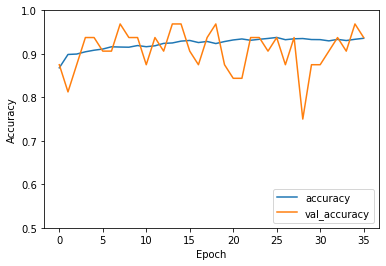

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
predict = vgg_model.predict(test)
y_pred = np.argmax(predict, axis=1)
y_test = np.argmax(test_labels, axis=1)
print('f1 Score : ',f1_score(y_test, y_pred, average="macro"))
print('recall  :',   recall_score(y_test,y_pred,average="macro"))
print('precision ',precision_score(y_test,y_pred,average="macro"))


f1 Score :  0.5055874727016105
recall  : 0.5072649572649572
precision  0.5078816914133549


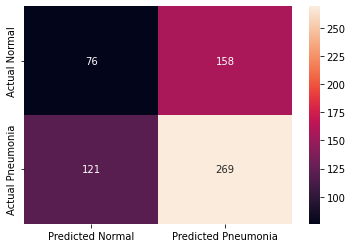

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.32      0.35       234
           1       0.63      0.69      0.66       390

    accuracy                           0.55       624
   macro avg       0.51      0.51      0.51       624
weighted avg       0.54      0.55      0.54       624



# Predection using vgg

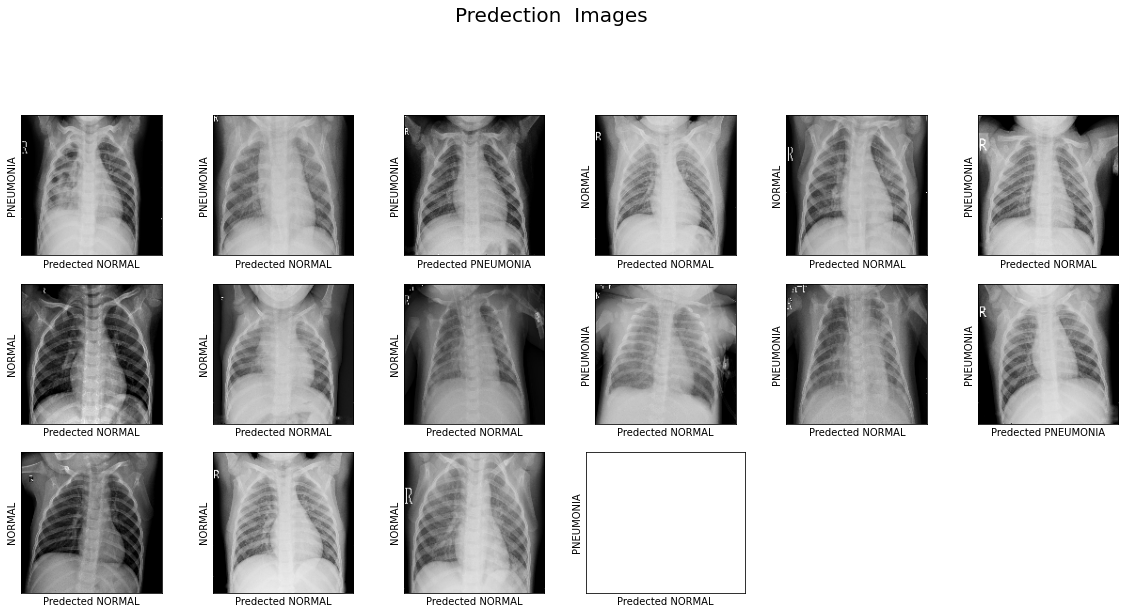

In [ ]:
plot_predection(vgg_model)

# InceptionResNetV2 Model

In [15]:
inseption_base_model = InceptionResNetV2(include_top=False, weights="imagenet", input_shape=(150,150,3), pooling="avg")

In [16]:
#remove any dense layer from model
freezing_layers(inseption_base_model)  

In [38]:
inseption = Sequential()
inseption.add(inseption_base_model)
inseption.add(layers.Flatten())
inseption.add(layers.Dense(2048 ,activation='relu'))
inseption.add(BatchNormalization())
inseption.add(Dropout(0.5))
inseption.add(layers.Dense(2, activation ='sigmoid'))
inseption.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 1536)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              1573888   
                                                                 
 batch_normalization_211 (Ba  (None, 1024)             4096      
 tchNormalization)                                               
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 2)                

In [39]:
inseption.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [40]:
# Training model
n_training_samples = len(train)
n_validation_samples = len(test)
history = inseption.fit(
    train,
    epochs=50,
    validation_data=test,
    validation_steps=n_validation_samples//batch_size,
    # steps_per_epoch =n_training_samples//batch_size,
    shuffle = True,
    callbacks=callbacks_list
    )

Epoch 1/50
20/20 [==============================] - 17s 298ms/step - loss: 0.6778 - accuracy: 0.7906 - val_loss: 1.6846 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 2s 105ms/step - loss: 0.4391 - accuracy: 0.8562 - val_loss: 0.4075 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 2s 106ms/step - loss: 0.3841 - accuracy: 0.8625 - val_loss: 0.4204 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 2s 110ms/step - loss: 0.3152 - accuracy: 0.8844 - val_loss: 3.4141 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 5/50
20/20 [==============================] - 2s 89ms/step - loss: 0.3573 - accuracy: 0.8594 - val_loss: 1.1692 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/50
20/20 [==============================] - ETA: 0s - loss: 0.3860 - accuracy: 0.8313
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
20/20 [==============================] - 2s 87ms/step -

In [24]:
predict = inseption.predict(test)

In [25]:
score, acc = inseption.evaluate(test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

39/39 [==============================] - 2s 49ms/step - loss: 0.3943 - accuracy: 0.8446
Test score: 0.3943018615245819
Test accuracy: 0.8445512652397156


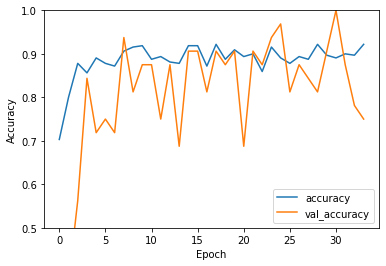

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [27]:
predict = inseption.predict(test)
y_pred = np.argmax(predict, axis=1)
y_test = np.argmax(test_labels, axis=1)
print('f1 Score : ',f1_score(y_test, y_pred, average="macro"))
print('recall  :',   recall_score(y_test,y_pred,average="macro"))
print('precision ',precision_score(y_test,y_pred,average="macro"))

f1 Score :  0.4667684672647452
recall  : 0.4747863247863248
precision  0.47007607776838545


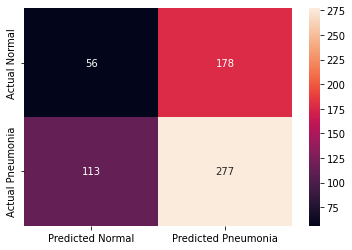

In [28]:
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.24      0.28       234
           1       0.61      0.71      0.66       390

    accuracy                           0.53       624
   macro avg       0.47      0.47      0.47       624
weighted avg       0.50      0.53      0.51       624



# Predection using Inception



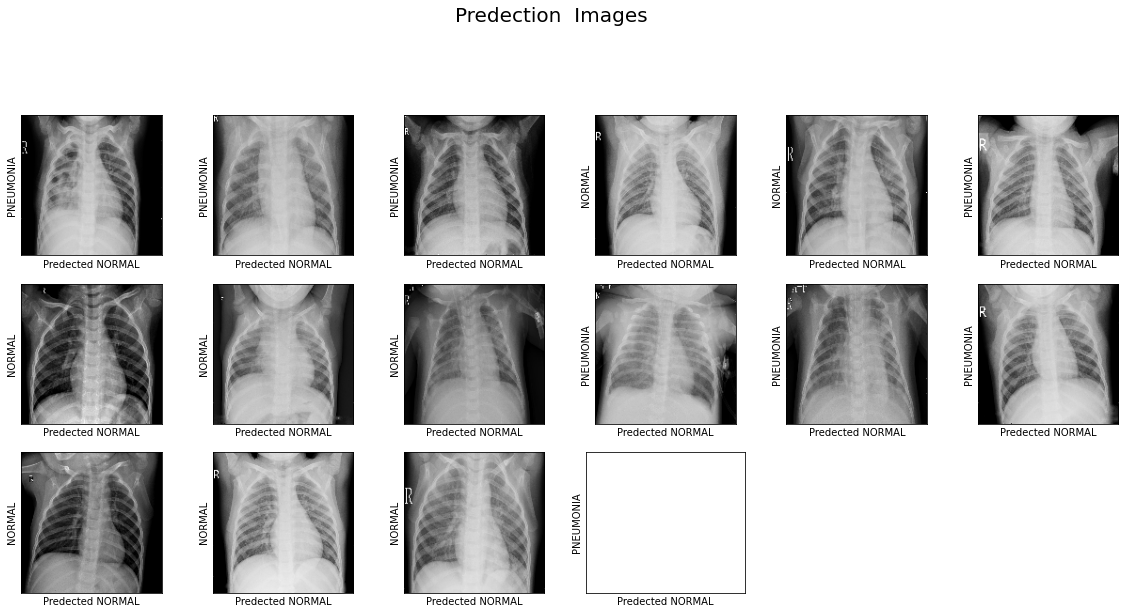

In [30]:
plot_predection(inseption) 

# Xception Model

In [31]:
xception_base_model = Xception(include_top=False,weights='imagenet',input_shape = (150,150,3))

83697664/83683744 [==============================] - 0s 0us/step


In [32]:
#remove any dense layer from model
freezing_layers(xception_base_model)

In [94]:
excmodel = Sequential()
excmodel.add(xception_base_model)
excmodel.add(layers.Flatten())
excmodel.add(layers.Dense(1024 ,activation='relu'))
excmodel.add(BatchNormalization())
excmodel.add(Dropout(0.5))
excmodel.add(layers.Dense(2, activation ='sigmoid'))
excmodel.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten_6 (Flatten)         (None, 51200)             0         
                                                                 
 dense_12 (Dense)            (None, 1024)              52429824  
                                                                 
 batch_normalization_213 (Ba  (None, 1024)             4096      
 tchNormalization)                                               
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 2)                 2050      
                                                      

In [95]:
excmodel.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [97]:
# Training model
n_training_samples = len(train)
n_validation_samples = len(test)
history = excmodel.fit(
    train,
    epochs=50,
    validation_data=test,
    validation_steps=n_validation_samples//batch_size,
    # steps_per_epoch =(n_training_samples//batch_size)*2,
    shuffle = True,
    callbacks=callbacks_list
    )

Epoch 1/50
40/40 [==============================] - 4s 91ms/step - loss: 0.3876 - accuracy: 0.8906 - val_loss: 0.8484 - val_accuracy: 0.5625 - lr: 1.0000e-06
Epoch 2/50
40/40 [==============================] - 3s 80ms/step - loss: 0.4027 - accuracy: 0.8953 - val_loss: 0.4377 - val_accuracy: 0.8438 - lr: 1.0000e-06
Epoch 3/50
40/40 [==============================] - 3s 79ms/step - loss: 0.4175 - accuracy: 0.8766 - val_loss: 0.3438 - val_accuracy: 0.9062 - lr: 1.0000e-06
Epoch 4/50
40/40 [==============================] - 3s 79ms/step - loss: 0.4342 - accuracy: 0.8656 - val_loss: 0.7157 - val_accuracy: 0.6875 - lr: 1.0000e-06
Epoch 5/50
40/40 [==============================] - 3s 81ms/step - loss: 0.4635 - accuracy: 0.8547 - val_loss: 0.7230 - val_accuracy: 0.6875 - lr: 1.0000e-06
Epoch 6/50
40/40 [==============================] - 3s 81ms/step - loss: 0.4291 - accuracy: 0.8719 - val_loss: 0.6776 - val_accuracy: 0.7188 - lr: 1.0000e-06
Epoch 7/50
40/40 [==============================] - 

In [98]:
score, acc = excmodel.evaluate(test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

39/39 [==============================] - 1s 30ms/step - loss: 0.5709 - accuracy: 0.7548
Test score: 0.570924699306488
Test accuracy: 0.754807710647583


In [ ]:
excmodel.save('/content/drive/MyDrive/model_result/chest_x_ray/x_ray_xception_92.5.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


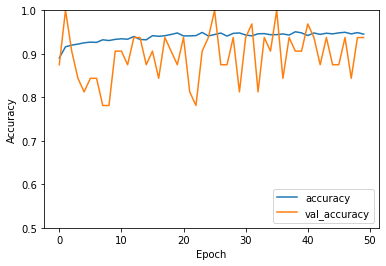

In [51]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [52]:
predict = excmodel.predict(test)
y_pred = np.argmax(predict, axis=1)
y_test = np.argmax(test_labels, axis=1)
print('f1 Score : ',f1_score(y_test, y_pred, average="macro"))
print('recall  :',   recall_score(y_test,y_pred,average="macro"))
print('precision ',precision_score(y_test,y_pred,average="macro"))

f1 Score :  0.49160714285714285
recall  : 0.49230769230769234
precision  0.49199908821518124


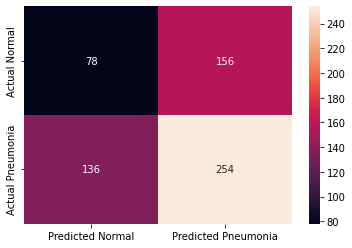

In [53]:
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.33      0.35       234
           1       0.62      0.65      0.64       390

    accuracy                           0.53       624
   macro avg       0.49      0.49      0.49       624
weighted avg       0.52      0.53      0.53       624



# Predection using Exception

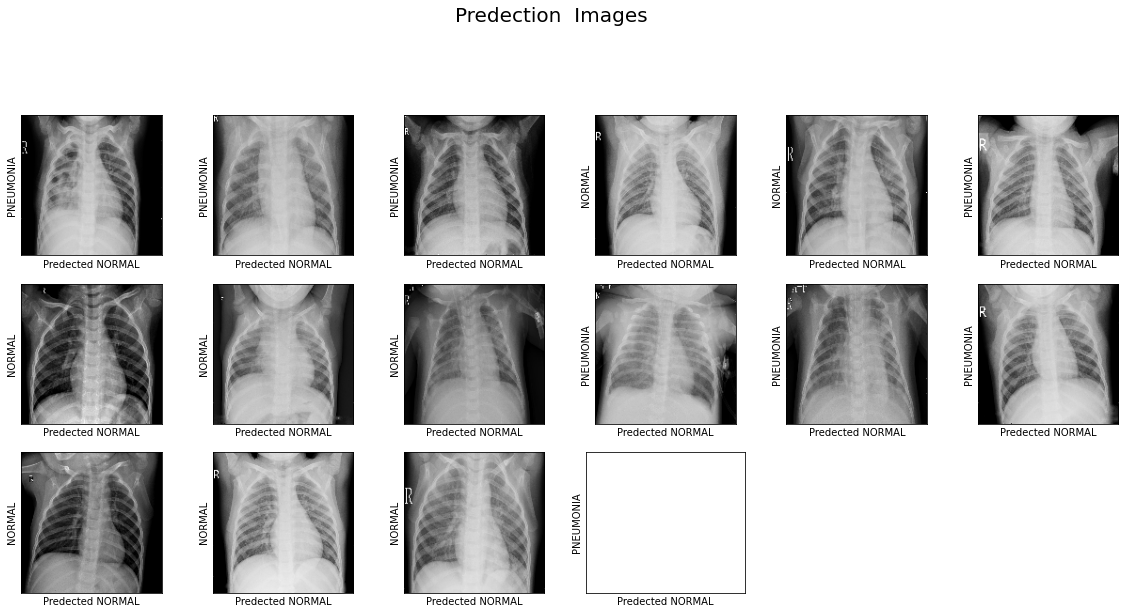

In [55]:
plot_predection(excmodel)